# 06 – Transfer Learning with YAMNet Embeddings (Full Sequence)

**Course:** CSCI 6366 (Neural Networks and Deep Learning)  
**Project:** Audio Classification using CNN  
**Notebook:** Transfer Learning with YAMNet Embeddings (Preserving Temporal Information)

---

## Overview

In this notebook, we explore an alternative approach to transfer learning with YAMNet.
Unlike `05_transfer_learning.ipynb` which averages embeddings over time, here we:

1. Extract **full sequence of embeddings** from YAMNet (preserving temporal information)
2. Pad or truncate embeddings to a fixed length (100 frames × 1024 dimensions)
3. Train a Dense neural network on the flattened embedding sequences
4. Compare this approach to our previous models

**Key Difference:**

- **Notebook 05**: Averages embeddings → single 1024-D vector per clip
- **This notebook**: Uses full sequence → (100, 1024) per clip → flattened to (100×1024,)

**Goals:**

- Preserve temporal information in YAMNet embeddings
- Train a classifier on full embedding sequences
- Evaluate and compare with previous approaches


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path

import soundfile as sf
import scipy.signal
import librosa
import librosa.display

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, models

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings('ignore')

# For reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Paths and constants
DATA_DIR = Path("../data").resolve()
SAMPLE_RATE = 16000  # YAMNet expects 16 kHz audio
MAX_FRAMES = 100  # Fixed number of embedding frames per clip

CLASS_NAMES = ["dog", "cat", "bird"]
print(f"Data directory: {DATA_DIR}")
print(f"Sample rate: {SAMPLE_RATE} Hz")
print(f"Max embedding frames: {MAX_FRAMES}")


Data directory: /Users/abhiyansainju/Desktop/GW Classes/Fall 2025/Neural Networks and Deep Learning CSCI_6366_80/Audio Classification/audio-classification-cnn/data
Sample rate: 16000 Hz
Max embedding frames: 100


## 2. Helper Functions: Audio Loading

We define a function to load audio files using librosa, which ensures proper float32 format compatible with both visualization and YAMNet.


In [ ]:
def read_audio(filename):
    """
    Read audio file using librosa (ensures float32 format).
    This is compatible with both librosa visualization and YAMNet.
    
    Args:
        filename: Path to audio file
    
    Returns:
        sample_rate, waveform (as numpy array, float32, normalized to [-1, 1])
    """
    # Use librosa.load which automatically:
    # - Converts to float32
    # - Normalizes to [-1, 1] range
    # - Converts to mono if stereo
    # - Resamples to desired sample rate
    wav_data, sample_rate = librosa.load(filename, sr=SAMPLE_RATE, mono=True, dtype=np.float32)
    
    return sample_rate, wav_data

# Test the function
test_file = list((DATA_DIR / "dog").glob("*.wav"))[0] if (DATA_DIR / "dog").exists() else None
if test_file:
    sr, wav = read_audio(str(test_file))
    print(f"✓ Test file loaded: {test_file.name}")
    print(f"  Sample rate: {sr} Hz")
    print(f"  Duration: {len(wav)/sr:.2f} seconds")
    print(f"  Shape: {wav.shape}")
    print(f"  Dtype: {wav.dtype}")


✓ Test file loaded: 62581901_nohash_0.wav
  Sample rate: 16000 Hz
  Duration: 1.00 seconds
  Shape: (16000,)


## 3. Load Dataset and Create DataFrame

We iterate through the data directory and collect audio data with their class labels.


In [5]:
# Gather audio data and labels
audio_data_list = []  # List of audio waveforms
labels_list = []  # List of class labels

print("Loading audio files...")
for class_name in CLASS_NAMES:
    class_dir = DATA_DIR / class_name
    if not class_dir.exists():
        print(f"⚠️  Warning: {class_dir} does not exist, skipping...")
        continue
    
    wav_files = list(class_dir.glob("*.wav"))
    print(f"Processing {len(wav_files)} files from '{class_name}'...")
    
    for wav_file in wav_files:
        try:
            sample_rate, wav_data = read_audio(str(wav_file))
            audio_data_list.append(wav_data)
            labels_list.append(class_name)
        except Exception as e:
            print(f"  ⚠️  Error loading {wav_file.name}: {e}")
            continue

print(f"\n✓ Dataset loaded: {len(audio_data_list)} samples")
print(f"\nClass distribution:")
label_counts = Counter(labels_list)
for class_name in CLASS_NAMES:
    count = label_counts.get(class_name, 0)
    print(f"  {class_name}: {count} samples")


Loading audio files...
Processing 210 files from 'dog'...
Processing 207 files from 'cat'...
Processing 193 files from 'bird'...

✓ Dataset loaded: 610 samples

Class distribution:
  dog: 210 samples
  cat: 207 samples
  bird: 193 samples


## 4. Visualize Sample Audio Files

Let's visualize waveforms from each class to understand the data.


ParameterError: Audio data must be floating-point

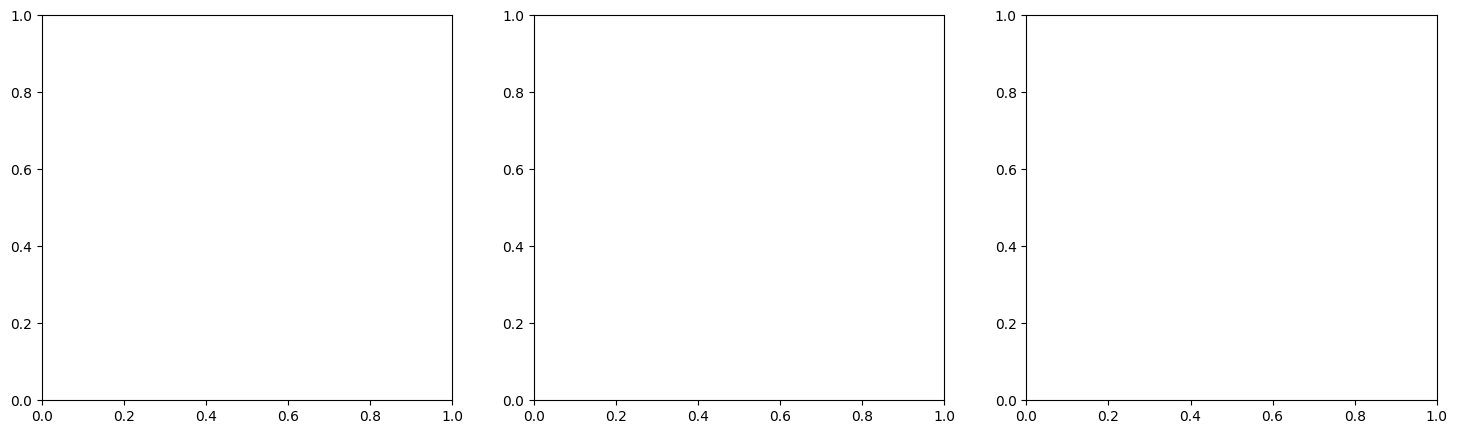

In [6]:
# Get one sample from each class
bird_idx = labels_list.index("bird") if "bird" in labels_list else None
cat_idx = labels_list.index("cat") if "cat" in labels_list else None
dog_idx = labels_list.index("dog") if "dog" in labels_list else None

# Visualize waveforms
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

if bird_idx is not None:
    librosa.display.waveshow(audio_data_list[bird_idx], sr=SAMPLE_RATE, ax=ax1)
    ax1.set_title("Bird", fontsize=14, fontweight='bold')
    ax1.set_ylabel("Amplitude")

if cat_idx is not None:
    librosa.display.waveshow(audio_data_list[cat_idx], sr=SAMPLE_RATE, ax=ax2)
    ax2.set_title("Cat", fontsize=14, fontweight='bold')

if dog_idx is not None:
    librosa.display.waveshow(audio_data_list[dog_idx], sr=SAMPLE_RATE, ax=ax3)
    ax3.set_title("Dog", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()
